# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override = True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [2]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini", temperature = 0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [3]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str # added custom key to inherited MessagesState

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [4]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [5]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [6]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

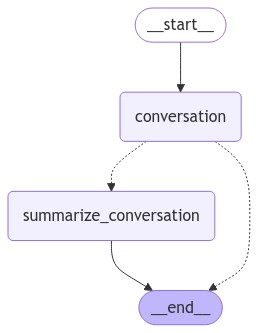

In [7]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver() # MemorySaver() is being used as the persistence layer
graph = workflow.compile(checkpointer=memory) # checkpointer is used here
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke(input = {"messages": [input_message]}, config = config) 
for m in output['messages'][-1:]:
    print(type(m))
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

<class 'langchain_core.messages.ai.AIMessage'>
================================== Ai Message ==================================

Hi Lance! How can I assist you today?
================================== Ai Message ==================================

Your name is Lance! How can I help you today?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that stands out to you?


In [9]:
graph.get_state(config).values.get("messages", "")

[HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='5268a65f-df2c-4a06-a042-6a7bd2c084dd'),
 AIMessage(content='Hi Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-9b8c4a3b-9903-4e83-a7de-e3a6ab46f3aa-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21}),
 HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='a3d81b1c-bb10-415d-902f-9aa7fe158cb3'),
 AIMessage(content='Your name is Lance! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 34, 'total_

Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [10]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [11]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

As of my last update, Nick Bosa signed a contract extension with the San Francisco 49ers in September 2023 that made him the highest-paid defensive player in NFL history at that time. His impact on the field has been significant, and he’s known for his exceptional skills as a pass rusher. Are you excited about the upcoming season?


In [12]:
for m in output["messages"]: 
    m.pretty_print()

================================ Human Message =================================

i like Nick Bosa, isn't he the highest paid defensive player?
================================== Ai Message ==================================

As of my last update, Nick Bosa signed a contract extension with the San Francisco 49ers in September 2023 that made him the highest-paid defensive player in NFL history at that time. His impact on the field has been significant, and he’s known for his exceptional skills as a pass rusher. Are you excited about the upcoming season?


In [13]:
graph.get_state(config).values.get("summary","")

"In the conversation, Lance introduces himself and shares his support for the San Francisco 49ers, specifically mentioning his admiration for player Nick Bosa. He inquires about Bosa's status as the highest-paid defensive player, to which it's confirmed that he signed a contract extension in September 2023 that made him the highest-paid defensive player in NFL history at that time. The conversation concludes with a question about Lance's excitement for the upcoming season."

## LangSmith

Let's review the trace!

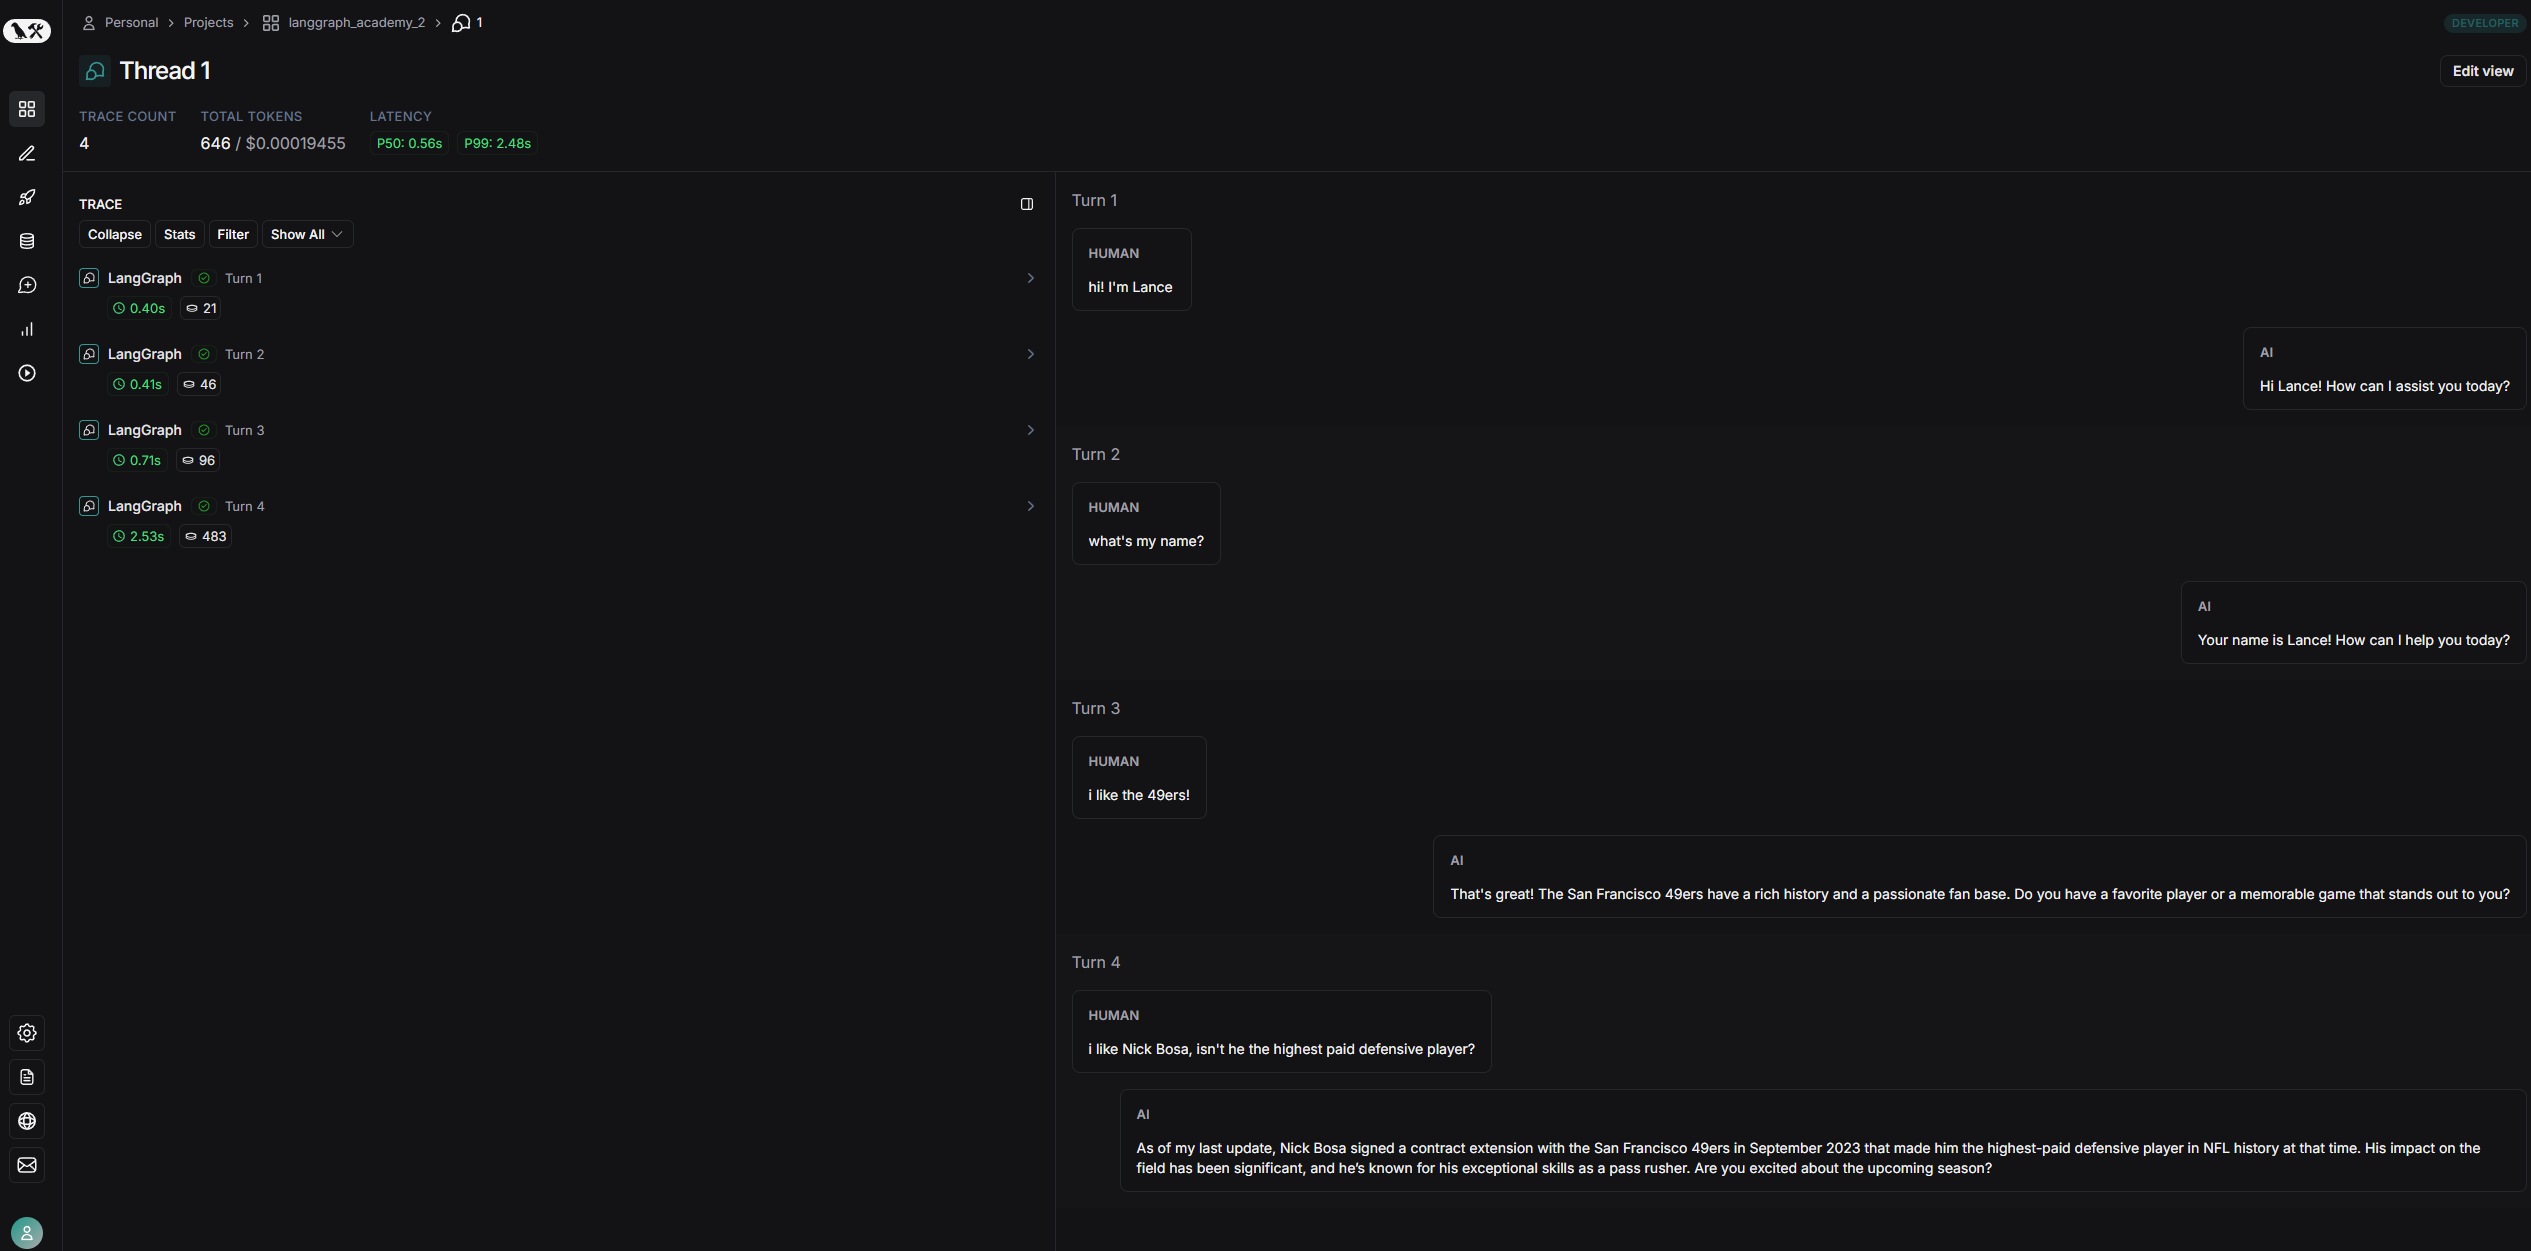

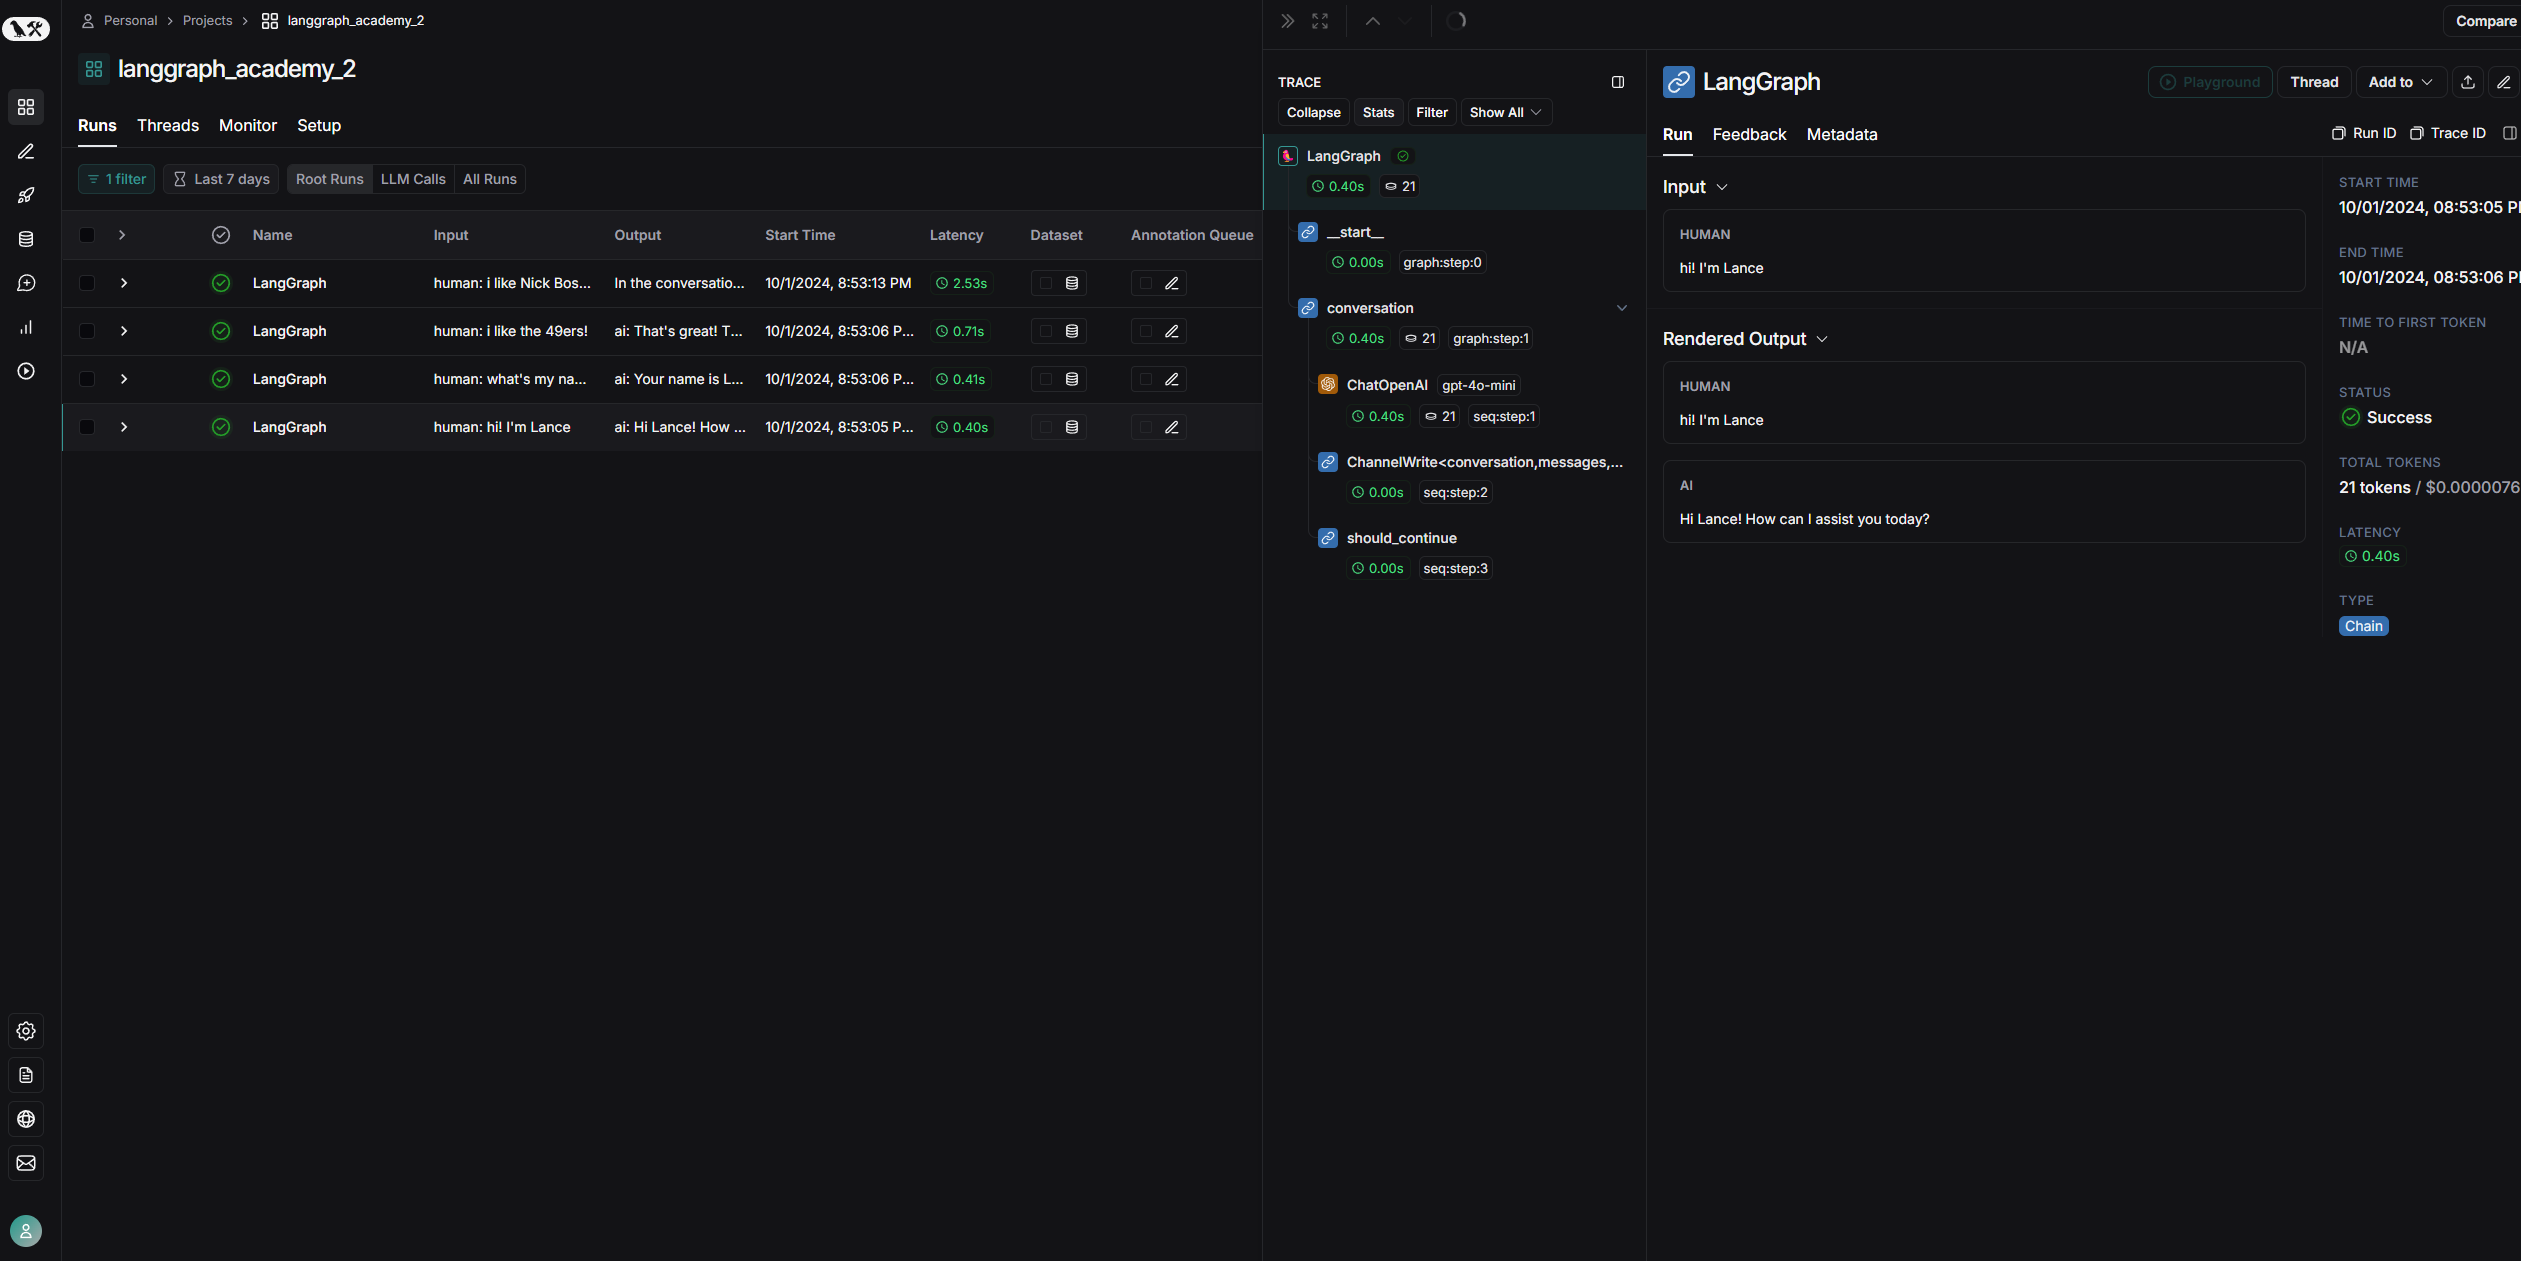

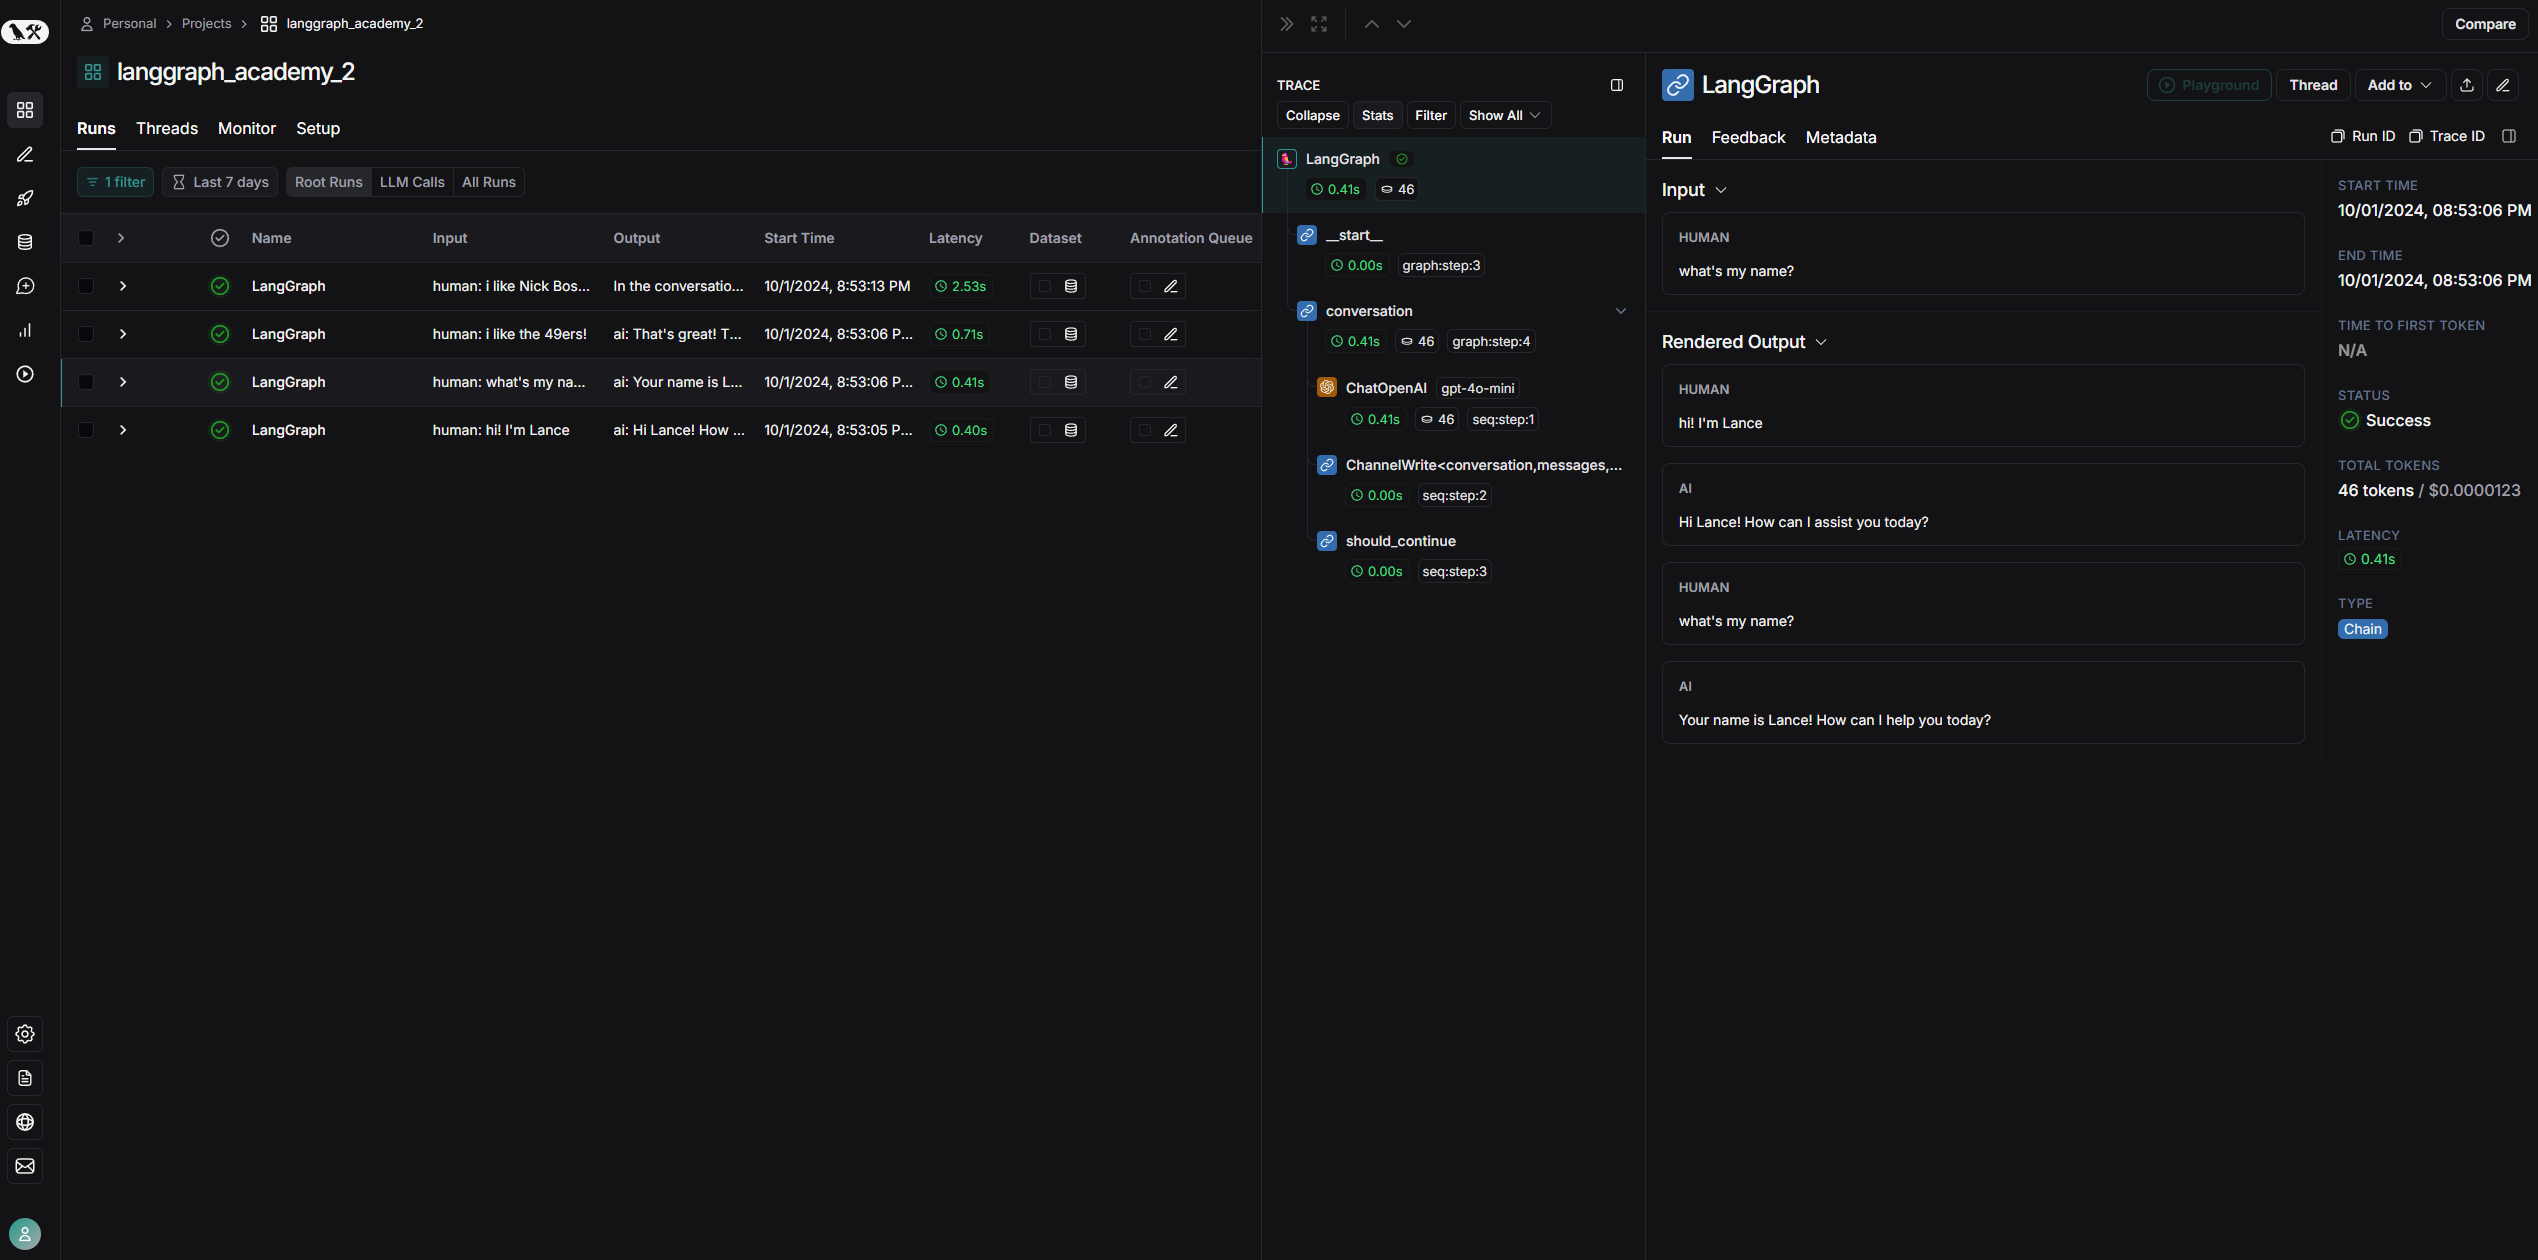

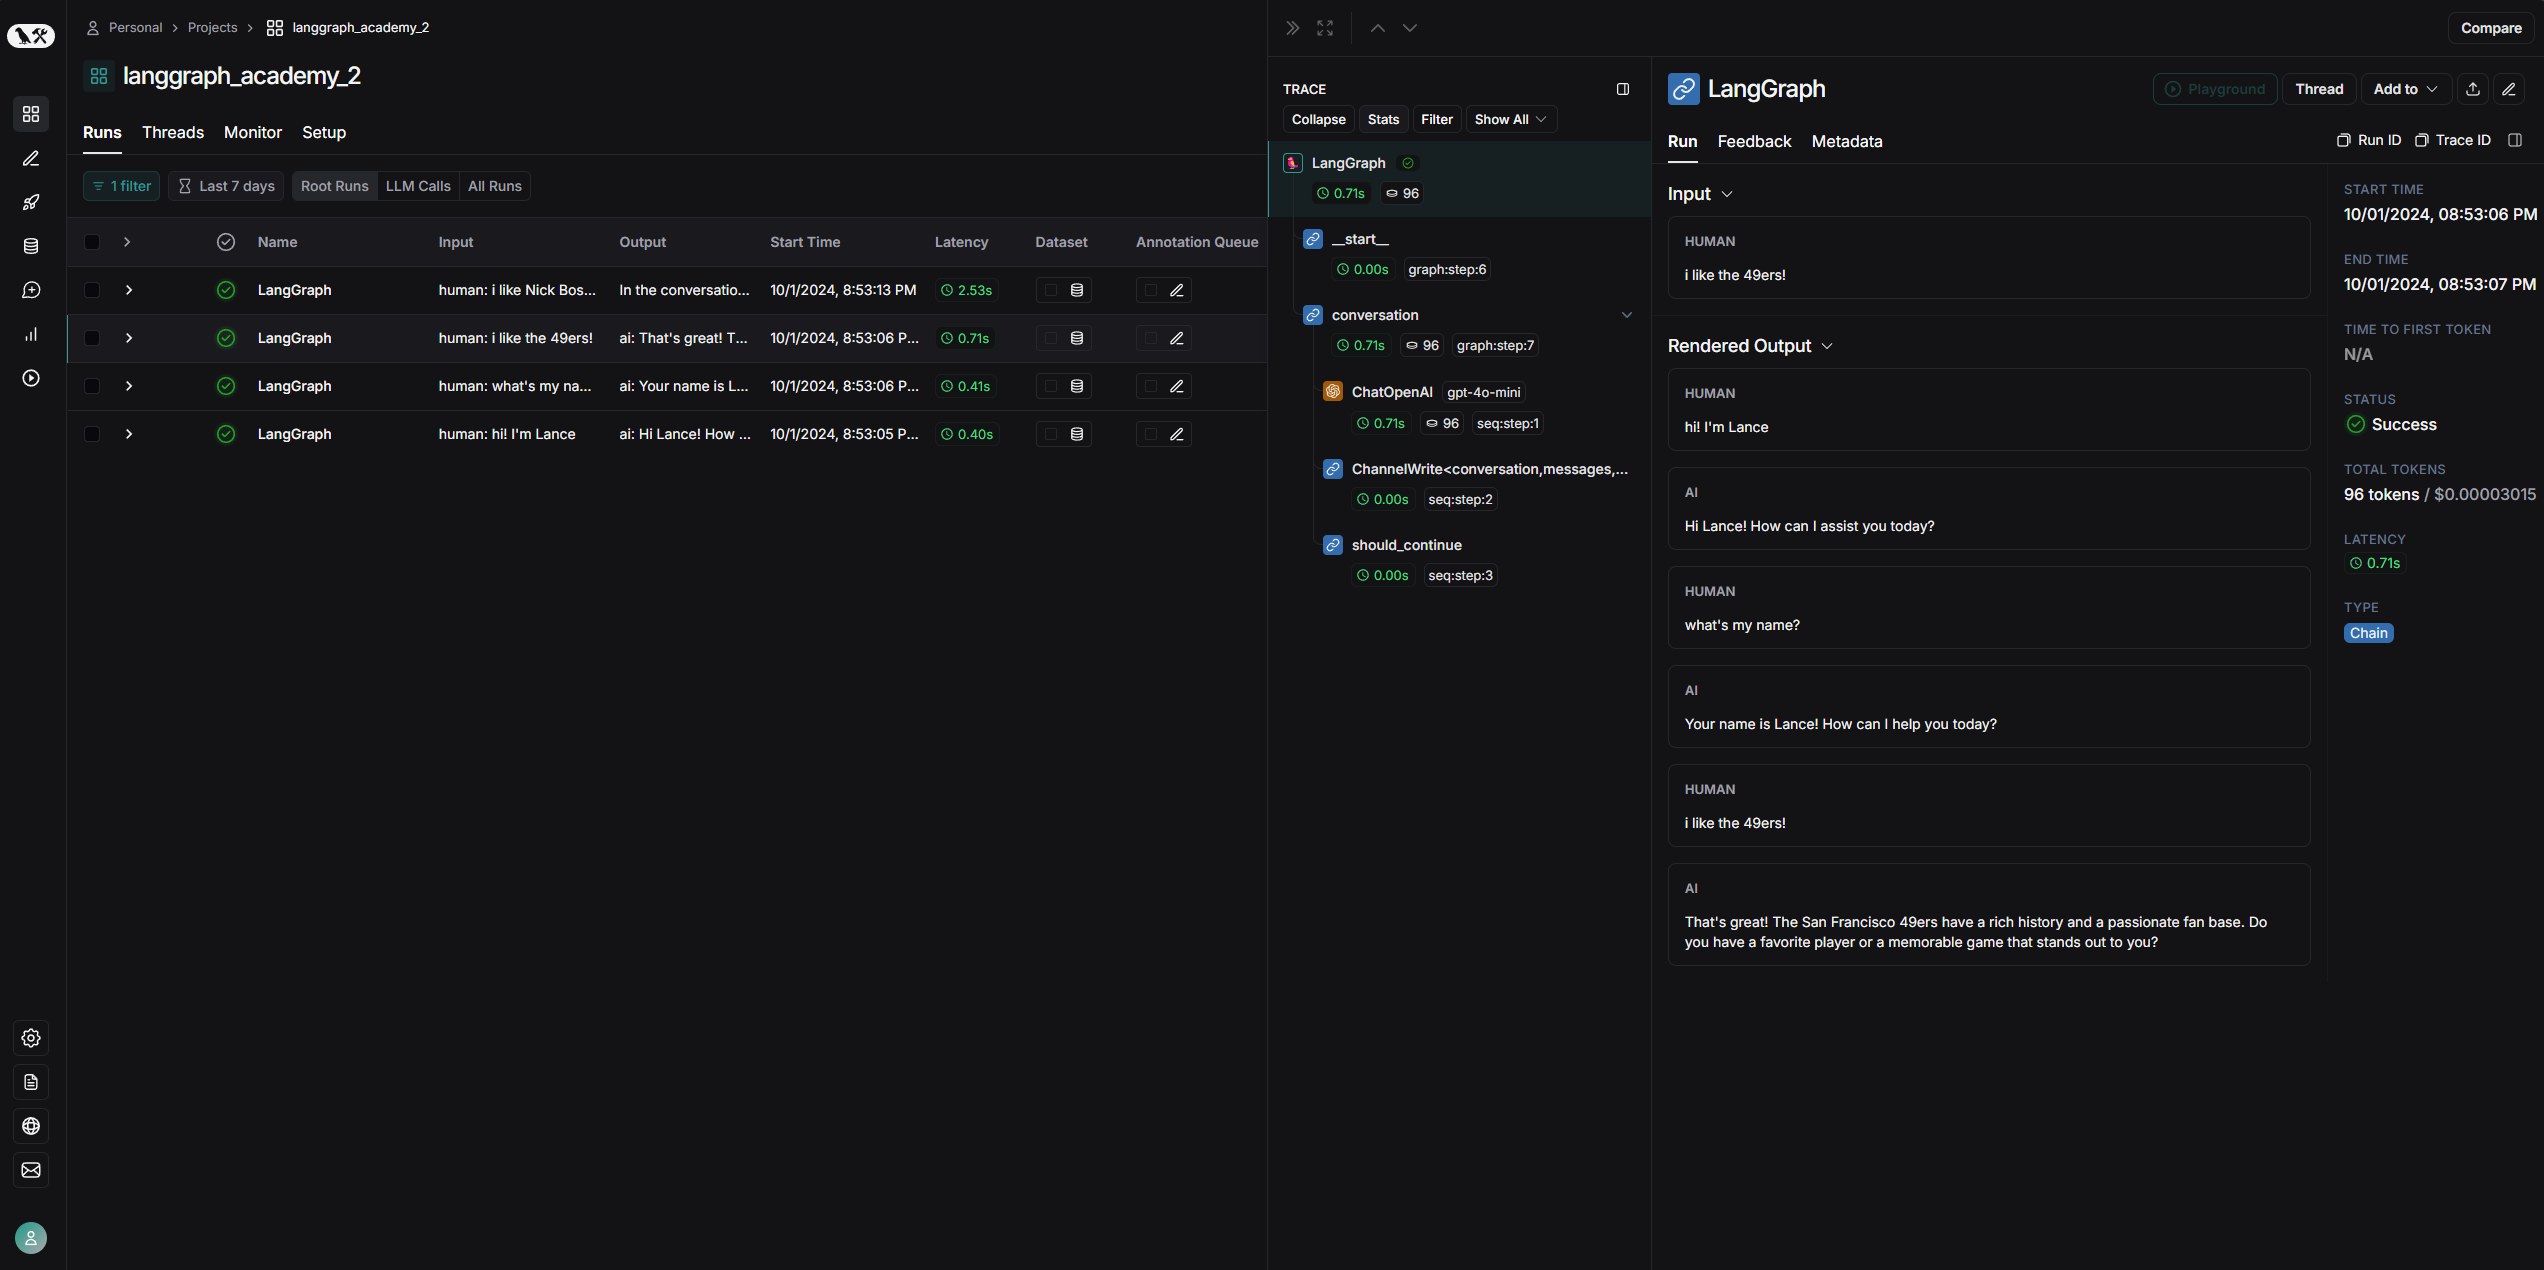

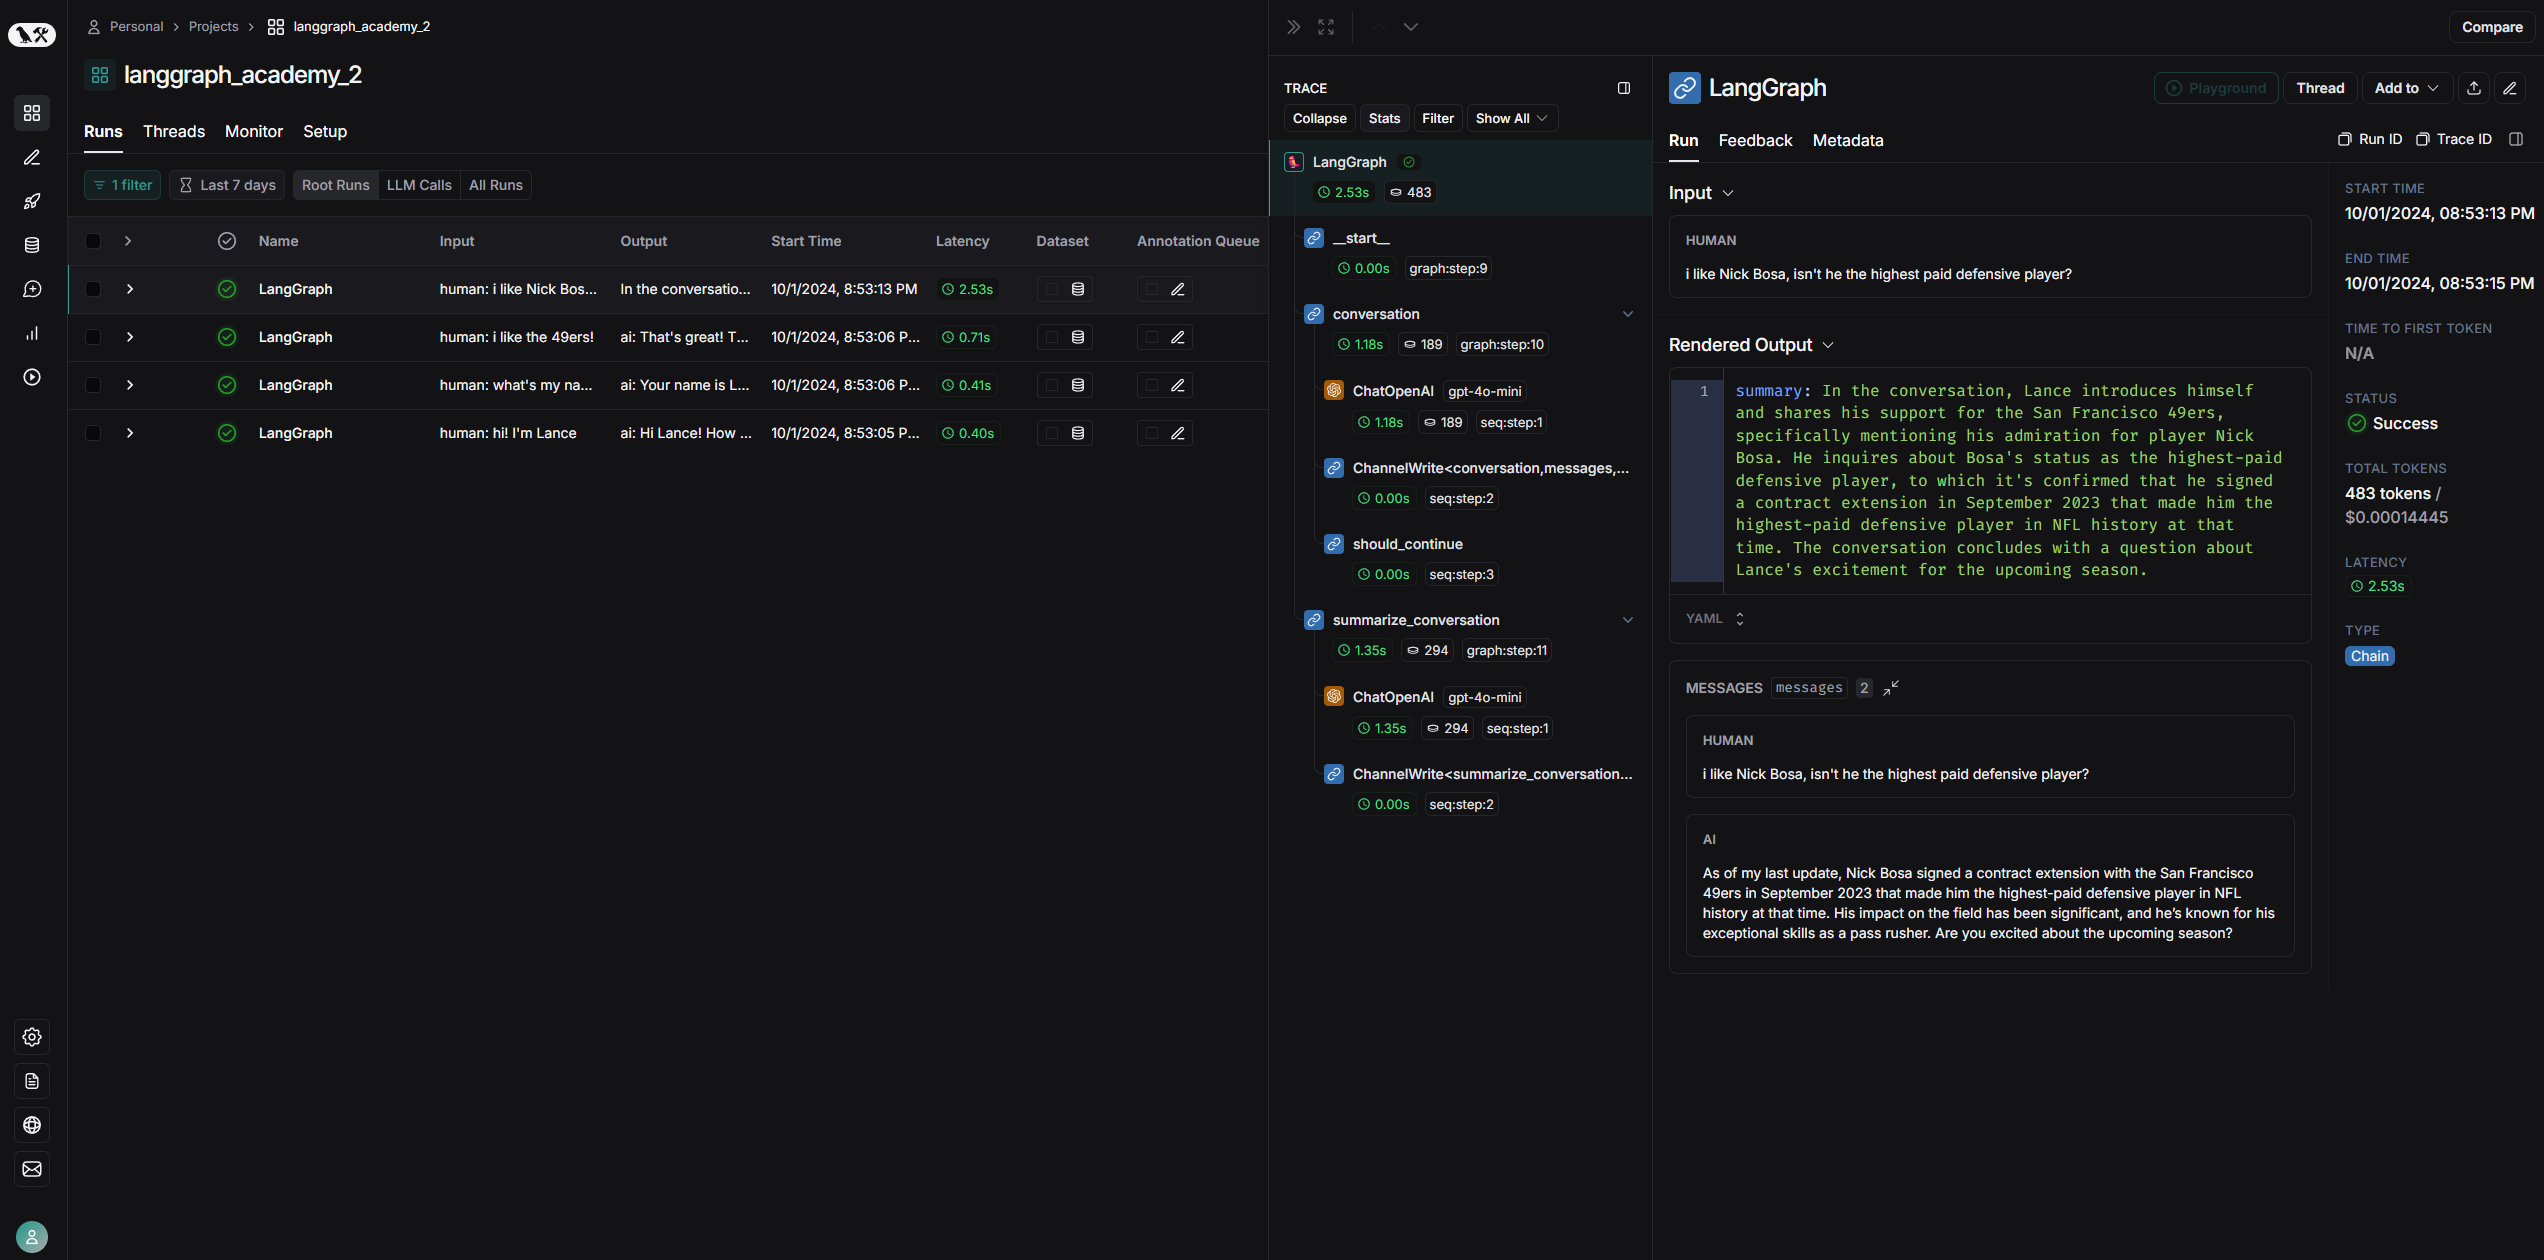